# Maximum likelihood method to estimate $s$ and $p_0$ using the real aDNA data

Why I'm doing this - previously I used an independent sites simulator and ABC to find a best fitting value of $s$ given the real aDNA data. Since then, filtering of the aDNA changed, so the estimates obtained by ABC are not accurate correct anymore. In fact, I didn't even try to estimate the $s$ precisely, I was exploring a rough grid of different $s$ values to make the job easier.

Luckily, there is another way how to achieve the same thing, more precisely, but without running 100k simulations to estimate $s$. Using the same assumption of selection on independent sites and a little bit of math one can obtain a MLE of the $s$ and initial $p$ in a much simpler and faster way.

In [7]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


### Function simulating the trajectories of a Nea. alleles given $s$, $h$ and $p_0$

It can simulate deterministic selection (no drift) on a single or multiple loci, or drift.

In [6]:
simulate_selection <- function(p0, s, h, total_time, N_loci=1, Ne=Inf) {
    # initialize the matrix of allele frequencies at each locus (columns)
    # in each generation (rows)
    if (N_loci > 1) p0 <- rep(p0, N_loci)
    p_trajectory <- matrix(c(p0, rep(0, N_loci * (total_time - 1))),
                           nrow=total_time,
                           byrow=TRUE)

    for (gen in seq_len(total_time)[-1]) {
        p <- p_trajectory[gen - 1, ]
        
        # fitnesses of all three genotypes (rows) at all loci (columns)
        fitnesses <- matrix(
            c(p ^ 2           * (1 + s),
              2 * p * (1 - p) * (1 + h * s),
              (1 - p) ^ 2     * 1),
            nrow=3,
            byrow=TRUE
        )

        # mean fitness of the whole population at individual loci
        mean_fitness <- apply(fitnesses, 2, sum)
        
        # calculate allele frequencies after selection
        p_next <- (fitnesses[1, ] + 0.5 * fitnesses[2, ]) / mean_fitness
        
        # calculate allele frequencies after binomial sampling (drift)
        if (Ne != Inf) {
            p_next <- rbinom(N_loci, 2 * Ne, p_next) / (2 * Ne)
        }
        
        p_trajectory[gen, ] <- p_next
    }

    p_trajectory
}

### Deterministic solution

To test the iterative results, we will compare them to the prediction of this deterministic function (ignoring the effect of drift) describing allele frequency at a single site as a function of $s$ and time. Eq. II-82 from Felsenstein PDF book adjusted appropriately for different expression of heterozygote fitness: $1 + s$ vs $1 + hs$ where $h = 1/2$ in this case.

In [3]:
deterministic_solution <- function(p0, s, t) {
    p0 * exp(s * t / 2) / (p0 * exp(s * t / 2) + (1 - p0))
}

### Test of the iterative models

Here I want to simply test the more generalized iterative solution by simulating drift at multiple loci under different modes of selection and comparing the results to the deterministic solution above.

In [4]:
simulate_and_plot <- function(p0, s, total_time, N_loci, Ne, h=0.5) {
    options(repr.plot.width=6, repr.plot.height=3)

    traj <- simulate_selection(p0, s, h, total_time, N_loci, Ne)

    # plot the average Nea. ancestry and the prediction from the theory
    print(
        qplot(x=1:total_time, y=apply(traj, 1, mean), geom="line",
              xlab="generations", ylab="frequency of the mutant allele",
              ylim=c(0, 1),
              main="Average Nea. frequencies (black) vs single-locus theory (red)") +
        geom_line(aes(x=1:total_time, y=sapply(1:total_time, function(g) { deterministic_solution(p0, s, t=g) })),
                  col="red")
    )

    # plot the individual Nea. allele frequencies and the prediction from the theory
    print(
        as.data.frame(traj) %>% mutate(gen=1:total_time) %>% gather(allele, freq, -gen) %>%
        ggplot(aes(gen, freq, group=allele)) + ylim(0, 1) +
        ggtitle("Nea. allele frequencies (black) vs single-locus theory (red)") +
        geom_line(size=0.05) +
        geom_line(aes(gen, freq, color="red"),
                  data=data.frame(gen=1:total_time,
                                  allele="theory",
                                  freq=sapply(1:total_time, function(g) { deterministic_solution(p0, s, t=g) }))) +
        theme(legend.position="none")
    )

    # plot the SFS of Nea. alleles
    #print(qplot(traj[total_time, ], bins=100, xlim=c(-0.05, 1.05), main="SFS of Nea. introgressed alleles"))
}

### Test of the neutral model

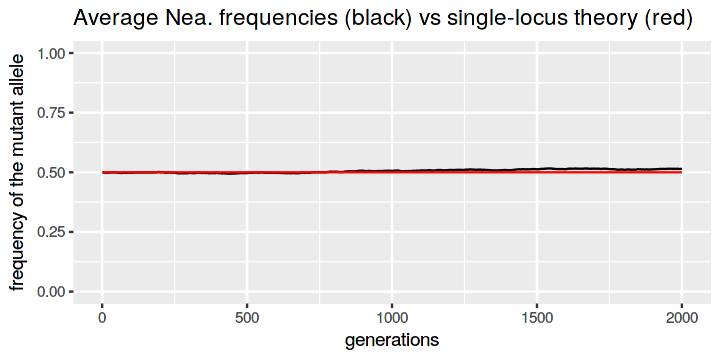

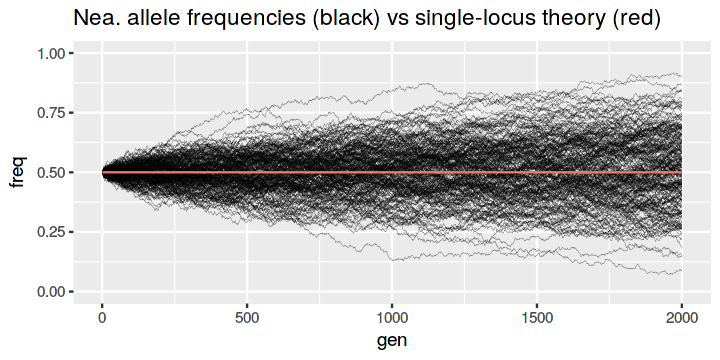

In [68]:
simulate_and_plot(p0=0.5, s=0.0, total_time=2000, N_loci=200, Ne=10000)

### Test of the negative selection model

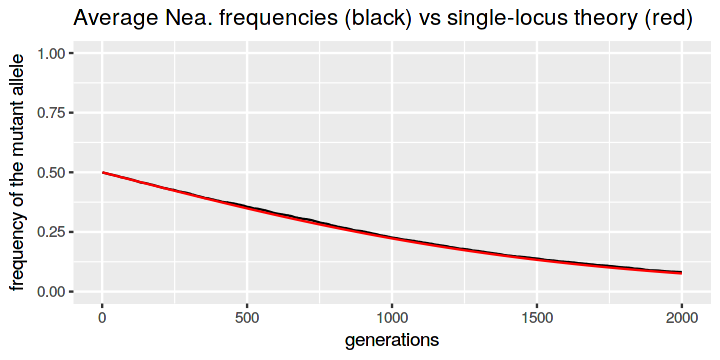

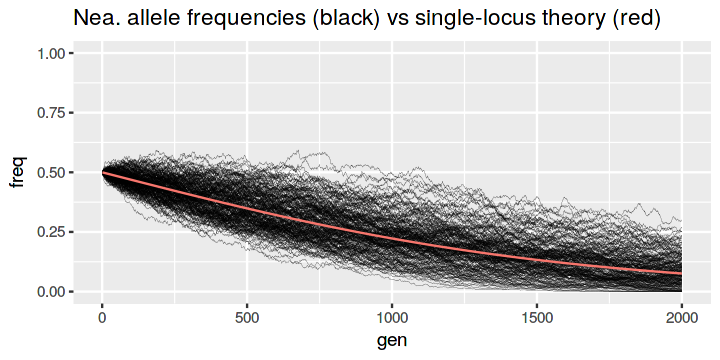

In [55]:
simulate_and_plot(p0=0.5, s=-0.0025, total_time=2000, N_loci=200, Ne=10000)

#### Test of the positive selection model

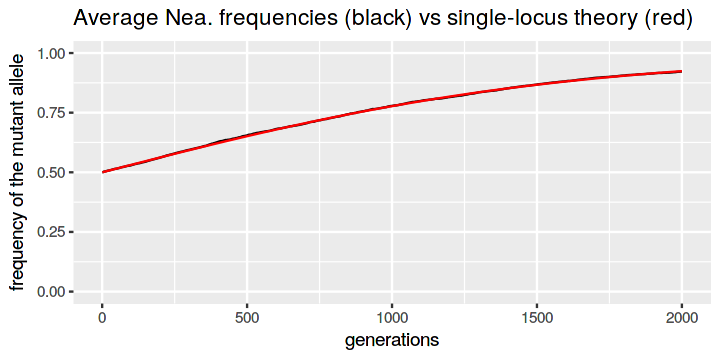

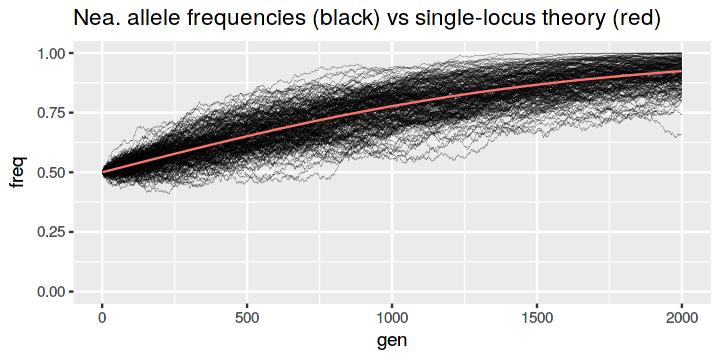

In [58]:
simulate_and_plot(p0=0.5, s=0.0025, total_time=2000, N_loci=200, Ne=10000)

## Example of the ML procedure on simulated data

#### Function to approximate noisy aDNA samples

Given a vector of times in generations and a simulated trajectory of Nea. ancestry proportions calculated using `simulate_selection` function we sample individual datapoints (aDNA individuals) at each specified time point (in generations after admixture).

The way it works is that we take the simulated Nea. trajectory at each time as a parameter $p$ in the binomial distribution, and sample from this binomial distribution `snp_count` SNPs and calculate the mean Nea. ancestry from these SNPs. This introduces a little bit of noise, approximating the noisy aDNA data we have.

In [4]:
sample_datapoints <- function(sample_times, traj, snp_count) {
    data.frame(
        nea=sapply(sample_times,
                   function(gen) {
                       mean(rbinom(snp_count, 1, traj[gen])) 
                   }),
        snp_count=snp_count,
        gen=sample_times
    )
}

Simulation of the trajectory of Nea. ancestry given (given $p_0$, $s$ and $h$) and sampling "aDNA samples" from this trajectory. We can see that the noisiness of the simulated data corresponds quite well to what we see in the real data.

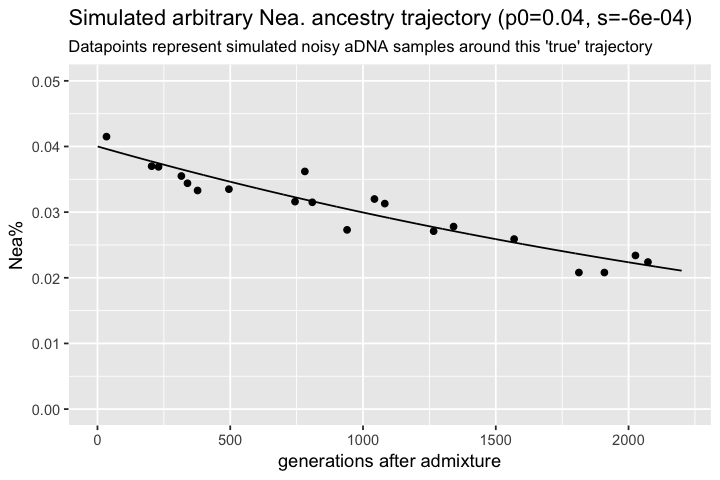

In [5]:
total_time <- 2200 # generations
sample_times <- sort(sample(1:2200, 20)) # ages of the 20 aDNA samples

p0 <- 0.04   # initial Nea. frequency
s <- -0.0006 # selection coefficient
h <- 0.5     # dominance coefficient

# simulate the selection against Nea. alleles with arbitrarily chosen
# parameters
traj <- simulate_selection(p0, s, h, total_time)

# sample aDNA samples
aDNA_samples <- sample_datapoints(sample_times, traj, snp_count=10000)

options(repr.plot.width=6, repr.plot.height=4)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, traj, geom="line", ylab="Nea%", xlab="generations after admixture", ylim=c(0, 0.05)) +
    geom_point(aes(gen, nea), data=aDNA_samples) +
    ggtitle(label=paste0("Simulated arbitrary Nea. ancestry trajectory (p0=", p0, ", s=", s, ")"),
            subtitle="Datapoints represent simulated noisy aDNA samples around this 'true' trajectory")

## Maximum likelihood method to fit $s$ and $p_0$ from the simulated data

We assume $h = 0.5$ and admixture 55 kya.

The idea is to find the set of parameters that maximize the likelihood of aDNA samples given the Nea. trajectory determined by these parameters.

### Negative log-likelihood function of the parameters $s$ and $p_0$ given aDNA data

The likelihood of each aDNA Neanderthal ancestry estimate is calculated as if it was drawn from a binomial distribution, with a parameter $p$ representing a Nea. ancestry value at a given time. Likelihoods of all samples are then combined together to generate a combined negative log-likelihood.

The number of SNPs available for each sample is taken into account during the binomial likelihood calculation (less SNPs available means higher tolerance for deviation from the Nea. ancestry value predicted by $p_0$ and $s$ in each iteration).

In [6]:
negLL <- function(param, real_data) {
    # parameters of the model
    p0 <- param[1] # initial Nea. ancestry
    s <- param[2]  # selection coefficient
    
    # simulate the Nea. ancestry trajectory determined by the parameters
    # and subset to the values corresponding to time points of the aDNA
    # samples
    sim_data <- as.vector(simulate_selection(p0,
                                             s,
                                             0.5,
                                             total_time=2200)[real_data$gen])
    
    # calculate the negative log-likelihoods of each individual aDNA point
    # (the number of Nea-like SNPs observed on all SNPs available for the sample)
    # given the parameters (actually, given the Nea. trajectory determined
    # by the parameters)
    -sum(dbinom(as.integer(real_data$nea * real_data$snp_count),
                real_data$snp_count,
                sim_data, log=TRUE))
}

In [7]:
negLL_det <- function(param, real_data) {
    # parameters of the model
    p0 <- param[1] # initial Nea. ancestry
    s <- param[2]  # selection coefficient
    
    # simulate the Nea. ancestry trajectory determined by the parameters
    # and subset to the values corresponding to time points of the aDNA
    # samples
    sim_data <- sapply(1:2200, function(t) deterministic_solution(p0, s, t))[real_data$gen]
    
    # calculate the negative log-likelihoods of each individual aDNA point
    # (the number of Nea-like SNPs observed on all SNPs available for the sample)
    # given the parameters (actually, given the Nea. trajectory determined
    # by the parameters)
    -sum(dbinom(as.integer(real_data$nea * real_data$snp_count),
                real_data$snp_count,
                sim_data, log=TRUE))
}

## Maximum likelihood using interative approach

In [8]:
# minimize the negative log-likelihood function
# start from arbitrary initial Nea 10% and s=-0.1
results <- optim(c(0.1, -0.1), negLL, real_data=aDNA_samples)

**MLE values** of the $p_0$ and $s$:

In [9]:
(mle_p0 <- results$par[1])
(mle_s <- results$par[2])

[1] 0.03963816

[1] -0.0005953824

## Maximum likelihood using deterministic approach

In [10]:
# minimize the negative log-likelihood function
# start from arbitrary initial Nea 10% and s=-0.1
results <- optim(c(0.1, -0.1), negLL_det, real_data=aDNA_samples)

**MLE values** of the $p_0$ and $s$:

In [11]:
(mle_p0 <- results$par[1])
(mle_s <- results$par[2])

[1] 0.03966792

[1] -0.0005959635

**Original values** of the $p_0$ and $s$ for comparison:

In [12]:
p0
s

[1] 0.04

[1] -6e-04

Yay! It works! The ML method was able to recover the true parameters $s$ and $p_0$ used for  simulating the data quite accurately.

Now we can use the same ML optimization method to estimate $s$ and $p_0$ in the real aDNA data.

## Maximum likelihood estimation of $s$ and $p_0$ using the real aDNA data

In [65]:
estimates <- read_tsv("../output/nea_estimates.tsv") %>% mutate(gen=as.integer((55000 - age) / 25))

Parsed with column specification:
cols(
  name = col_character(),
  nea = col_double(),
  age = col_integer(),
  snp_count = col_integer()
)


In [66]:
head(estimates)

name,nea,age,snp_count,gen
UstIshim,0.02817580,45020,479930,399
Kostenki14,0.02656486,37470,400947,701
GoyetQ116_1,0.02880845,34795,97356,808
Muierii2,0.02226141,33300,14154,868
Vestonice13,0.02894517,30870,23091,965
Vestonice16,0.02552449,30010,172180,999


## Maximum likelihood using interative approach

In [67]:
results <- optim(c(0.1, -0.01), negLL, real_data=estimates)

**MLE values** of the $p_0$ and $s$:

In [68]:
(mle_p0 <- results$par[1])
(mle_s <- results$par[2])

[1] 0.03152605

[1] -0.0004911172

## Maximum likelihood using deterministic approach

In [69]:
results <- optim(c(0.1, -0.01), negLL_det, real_data=estimates)

**MLE values** of the $p_0$ and $s$:

In [70]:
(mle_p0 <- results$par[1])
(mle_s <- results$par[2])

[1] 0.03146709

[1] -0.0004892488

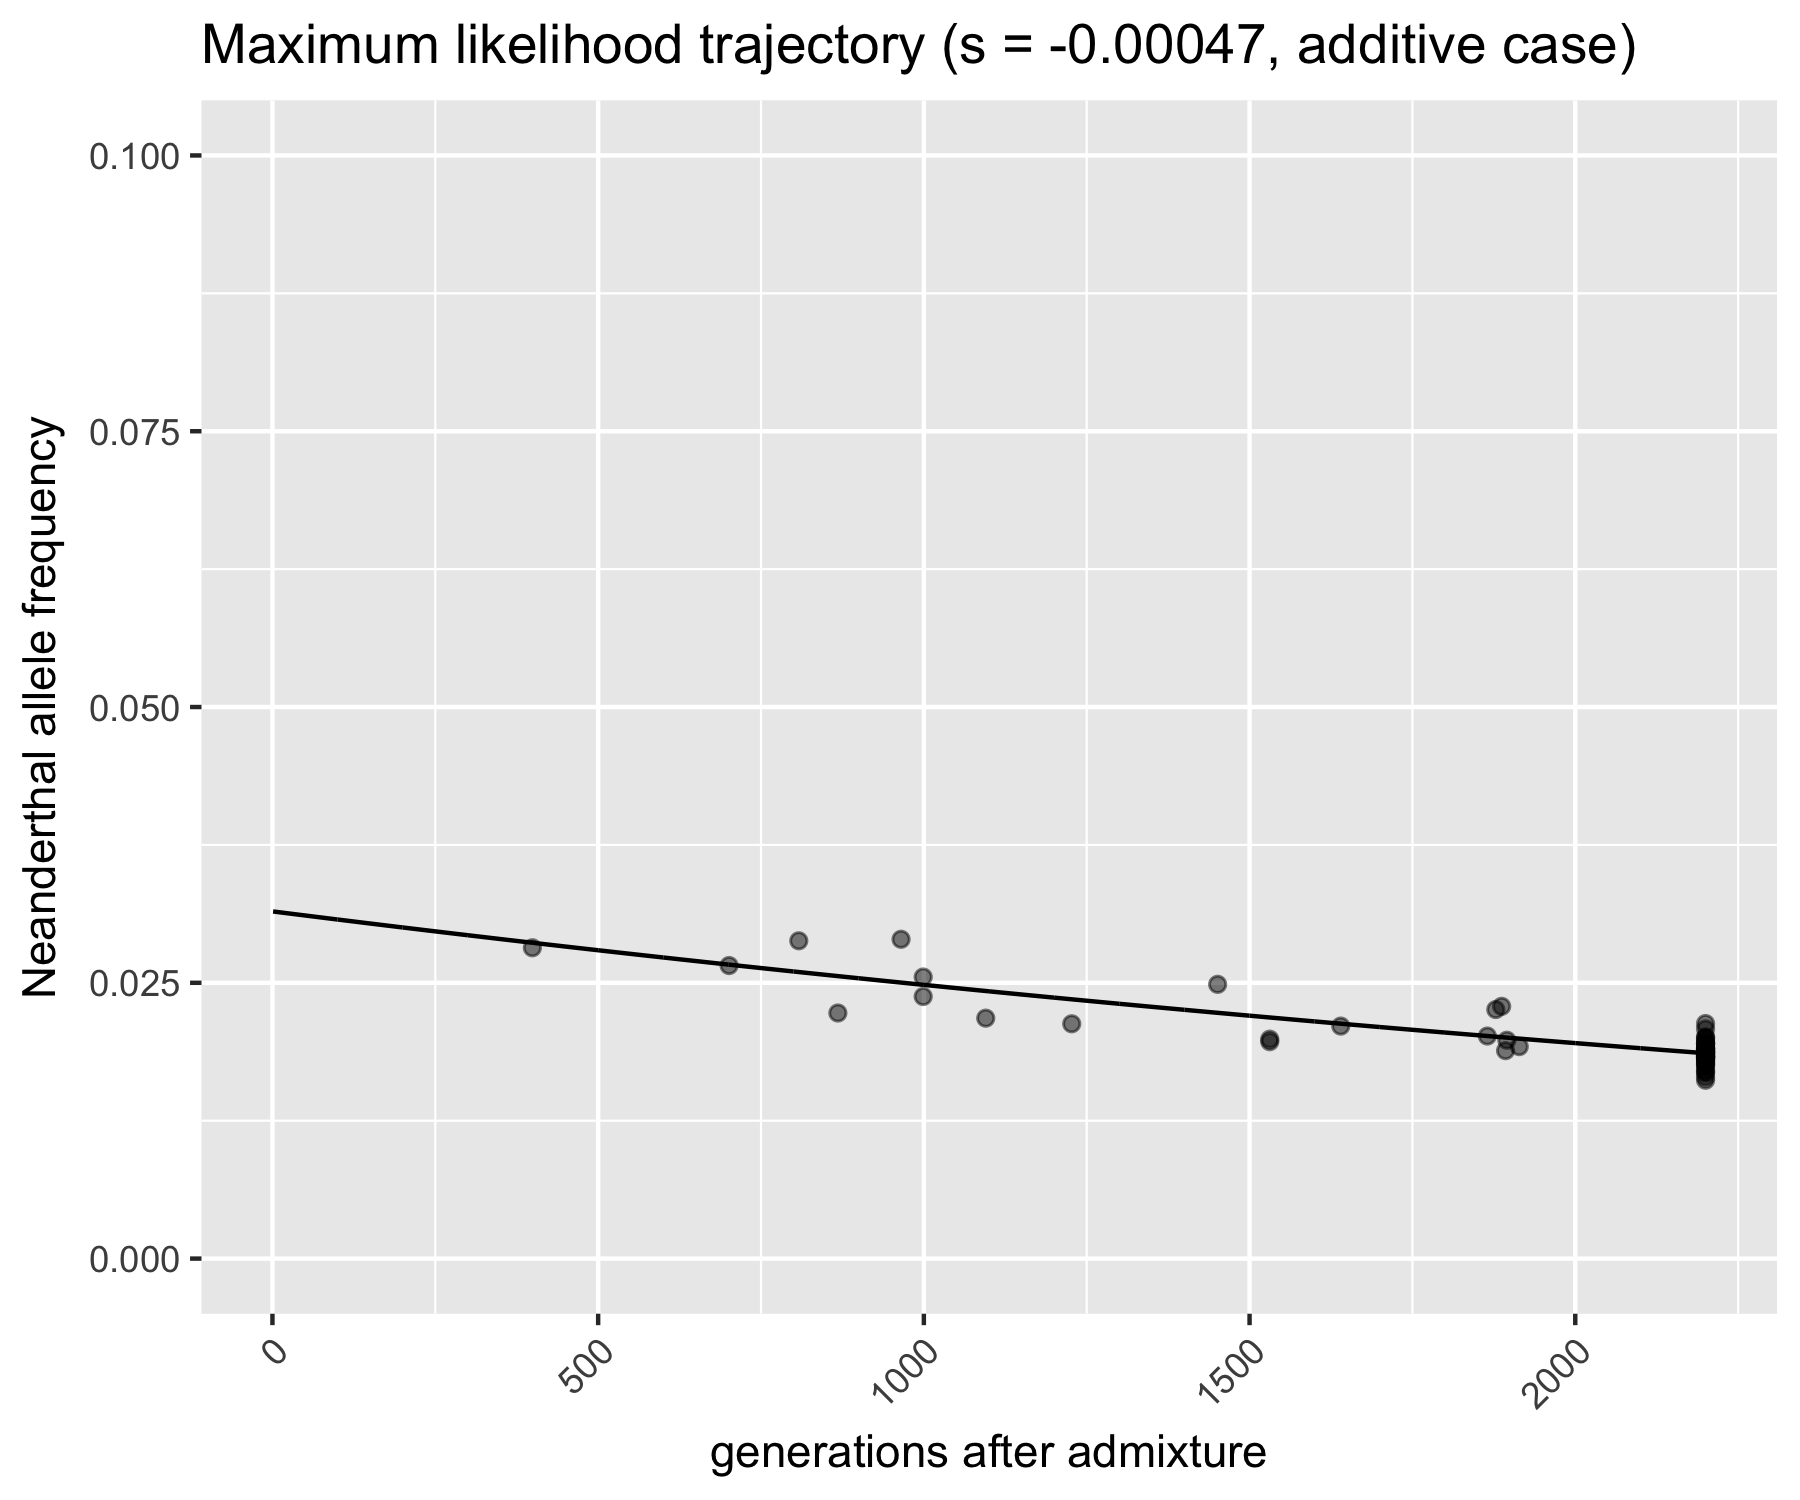

In [73]:
# SMBE
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res=300)

total_time <- 2200 # generations

# simulate the selection against Nea. alleles using the MLE of parameters
mle_traj <- simulate_selection(mle_p0, mle_s, 0.5, total_time)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, mle_traj, geom="line", ylab="Neanderthal allele frequency",
      xlab="generations after admixture", ylim=c(0, 0.1)) +
    geom_point(aes(gen, nea), data=estimates, alpha=1/2) +
#    ggtitle(label=paste0("Maximum likelihood trajectory (s = ", round(mle_s, digits=5), ", h = 0.5)")) +
    ggtitle(label=paste0("Maximum likelihood trajectory (s = -0.00047, additive case)")) +
    theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none")

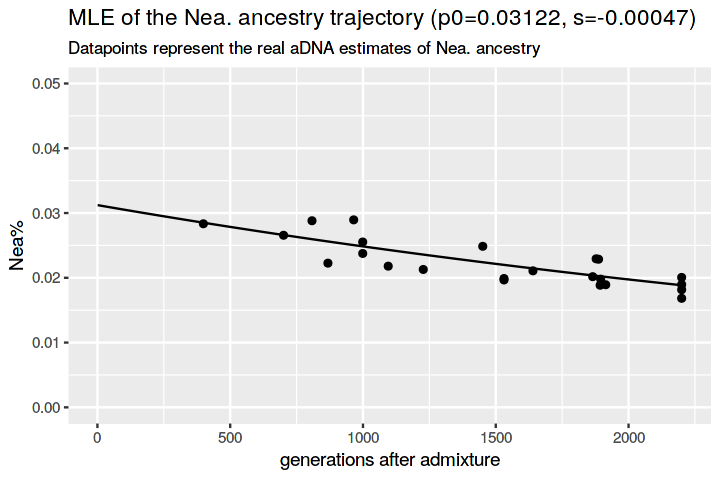

In [15]:
options(repr.plot.width=6, repr.plot.height=4)

total_time <- 2200 # generations

# simulate the selection against Nea. alleles using the MLE of parameters
mle_traj <- simulate_selection(mle_p0, mle_s, 0.5, total_time)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, mle_traj, geom="line", ylab="Nea%", xlab="generations after admixture", ylim=c(0, 0.05)) +
    geom_point(aes(gen, nea), data=estimates) +
    ggtitle(label=paste0("MLE of the Nea. ancestry trajectory (",
                         "p0=", round(mle_p0, digits=5), ", ",
                         "s=", round(mle_s, digits=5), ")"),
            subtitle="Datapoints represent the real aDNA estimates of Nea. ancestry")

# Simulating independent-sites selection using DFE from SLiM

We sample the deleterious Nea. mutations weighted by their frequency and run the iterative simulation function with $s$ of each site sampled from the simulated SLiM DFE

In [13]:
source("../R/process_slim_output.R")


Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract



Load the deleterious mutations after burnin & split demography:

In [14]:
slim_file <- read_slim_file("../simulations/exome_and_sites__h_0.5__seed_6977220333793.txt")

nea_muts <- read_mutations(slim_file, "m0", "p2")         %>% mutate(freq=count / (2 * 1000), mutations="Nea", pop_origin="Nea")
mh_muts <- read_mutations(slim_file, "m0", "p1", t=50000) %>% mutate(freq=count / (2 * (10000 + 1861)), mutations="AMH", pop_origin="AMH")

before_admixture <- rbind(mh_muts, nea_muts)

Check the SFS of AMH and Nea. specific deleterious mutations:

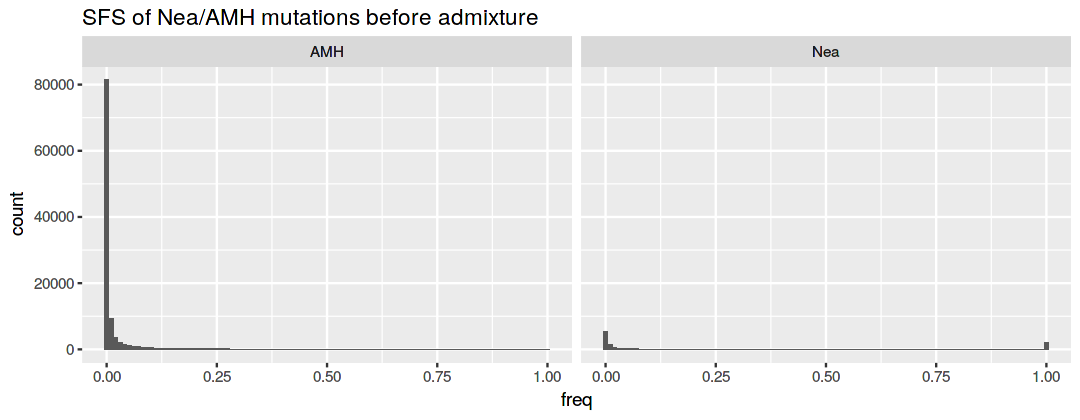

In [15]:
options(repr.plot.width=9, repr.plot.height=3.5)

ggplot(before_admixture, aes(freq)) +
    geom_histogram(bins=100) +
    facet_grid(. ~ mutations) + ggtitle("SFS of Nea/AMH mutations before admixture") +
    theme(legend.position="bottom")

Distributions of $s$ in both populations before the admixture:

Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"

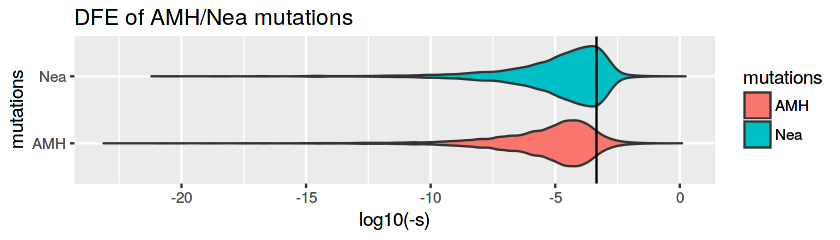

In [57]:
options(repr.plot.width=7, repr.plot.height=2)

ggplot(before_admixture, aes(mutations, log10(-s), fill=mutations)) +
    geom_violin(aes(weight=freq)) + coord_flip() + ggtitle("DFE of AMH/Nea mutations") +
    geom_hline(yintercept=log10(-mle_s), color="black")

In [17]:
modus <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

In [60]:
group_by(before_admixture, pop_origin) %>%
summarise(mean(s, weights=freq), median(s), modus(s))

pop_origin,"mean(s, weights = freq)",median(s),modus(s)
AMH,-0.01829569,-0.0009018900,-1.02219e-05
Nea,-0.01619916,-0.0005328225,-1.96107e-03


Read the DFE after 30 generations of SLiM simulation:

In [30]:
slim_file <- read_slim_file("../simulations/different_models/constant__h_0.5__init_nea_0.1__rep_1__dump_gen_30.txt")
N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size
after_admixture <- read_mutations(slim_file, "m0", "p2") %>%
    mutate(mutations="Nea", freq=count / (2 * N))

Sample `N_loci` selection coefficients from the Nea. DFE, weighted by frequency:

In [31]:
N_loci <- 30000

dfe_before_admixture <- filter(before_admixture, mutations == "Nea") %>%
    sample_n(N_loci, weight=freq, replace=TRUE) %>%
    .[["s"]]

dfe_after_admixture <- filter(after_admixture, mutations == "Nea") %>%
    sample_n(N_loci, weight=freq, replace=TRUE) %>%
    .[["s"]]

In [32]:
dfe_traj_before <- simulate_selection(mle_p0, dfe_before_admixture, 0.5, total_time, N_loci, Ne=10000)
dfe_traj_after <- simulate_selection(mle_p0, dfe_after_admixture, 0.5, total_time, N_loci, Ne=10000)

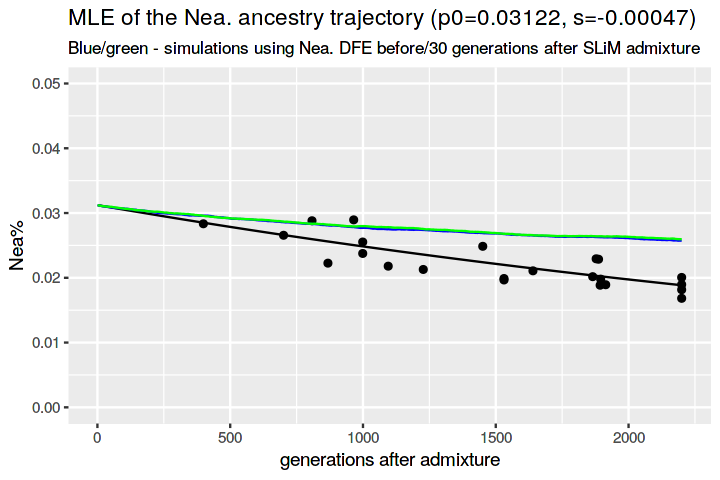

In [36]:
options(repr.plot.width=6, repr.plot.height=4)

total_time <- 2200 # generations

# simulate the selection against Nea. alleles using the MLE of parameters
mle_traj <- simulate_selection(mle_p0, mle_s, 0.5, total_time)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, mle_traj, geom="line", ylab="Nea%", xlab="generations after admixture", ylim=c(0, 0.05)) +
    geom_point(aes(gen, nea), data=estimates) +
    geom_line(aes(x=1:total_time, y=apply(dfe_traj_before, 1, mean)), color="blue") +
    geom_line(aes(x=1:total_time, y=apply(dfe_traj_after, 1, mean)), color="green") +
    ggtitle(label=paste0("MLE of the Nea. ancestry trajectory (",
                         "p0=", round(mle_p0, digits=5), ", ",
                         "s=", round(mle_s, digits=5), ")"),
            subtitle="Blue/green - simulations using Nea. DFE before/30 generations after SLiM admixture")

# Frequency vs derivative

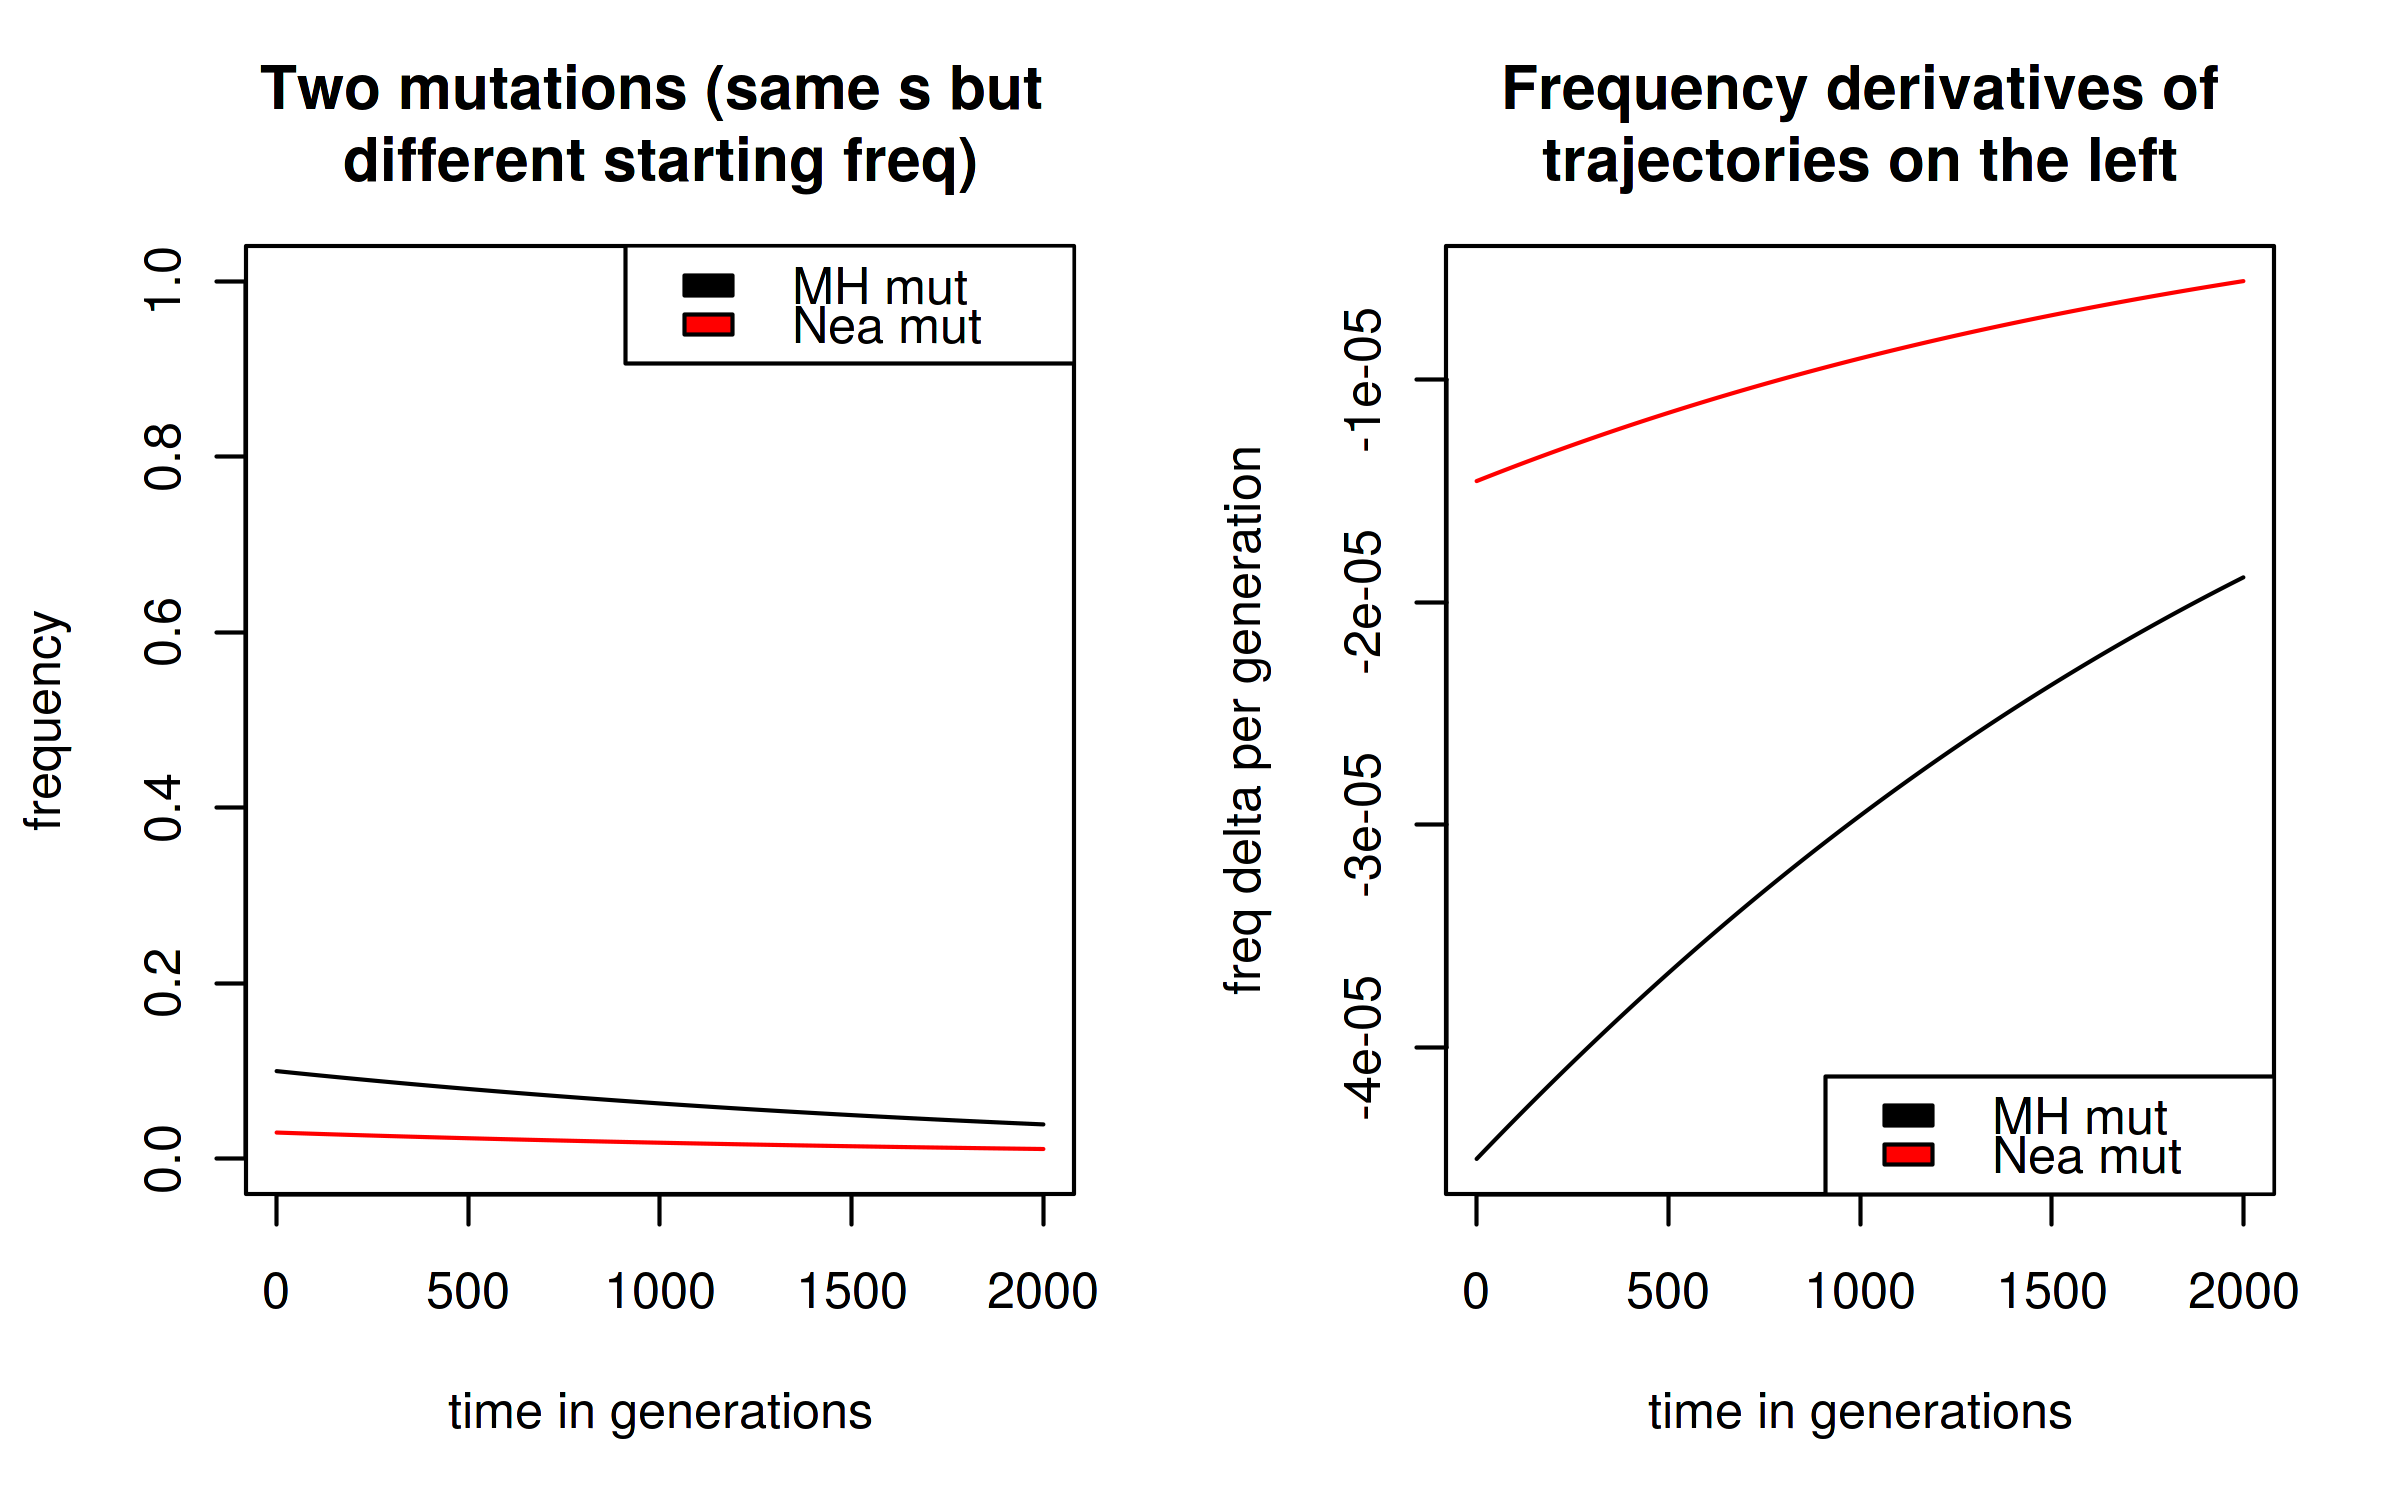

In [87]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=300)

mh <- simulate_selection(0.1, -0.001, 0.5, 2000) %>% .[, 1]
nea <- simulate_selection(0.03, -0.001, 0.5, 2000) %>% .[, 1]

par(mfrow=c(1, 2))
plot(1:2000, mh, ylim=c(0, 1), type="l", ylab="frequency", xlab="time in generations",
     main="Two mutations (same s but \ndifferent starting freq)")
lines(1:2000, nea, col="red")
legend("topright", fill=c("black", "red"), legend=c("MH mut", "Nea mut"))

plot(1:1999, diff(nea), col="red", type="l", ylab="freq delta per generation", xlab="time in generations",
     main="Frequency derivatives of\ntrajectories on the left",
     ylim=c(min(c(diff(nea), diff(mh))), max(c(diff(nea), diff(mh)))))
lines(1:1999, diff(mh))
legend("bottomright", fill=c("black", "red"), legend=c("MH mut", "Nea mut"))

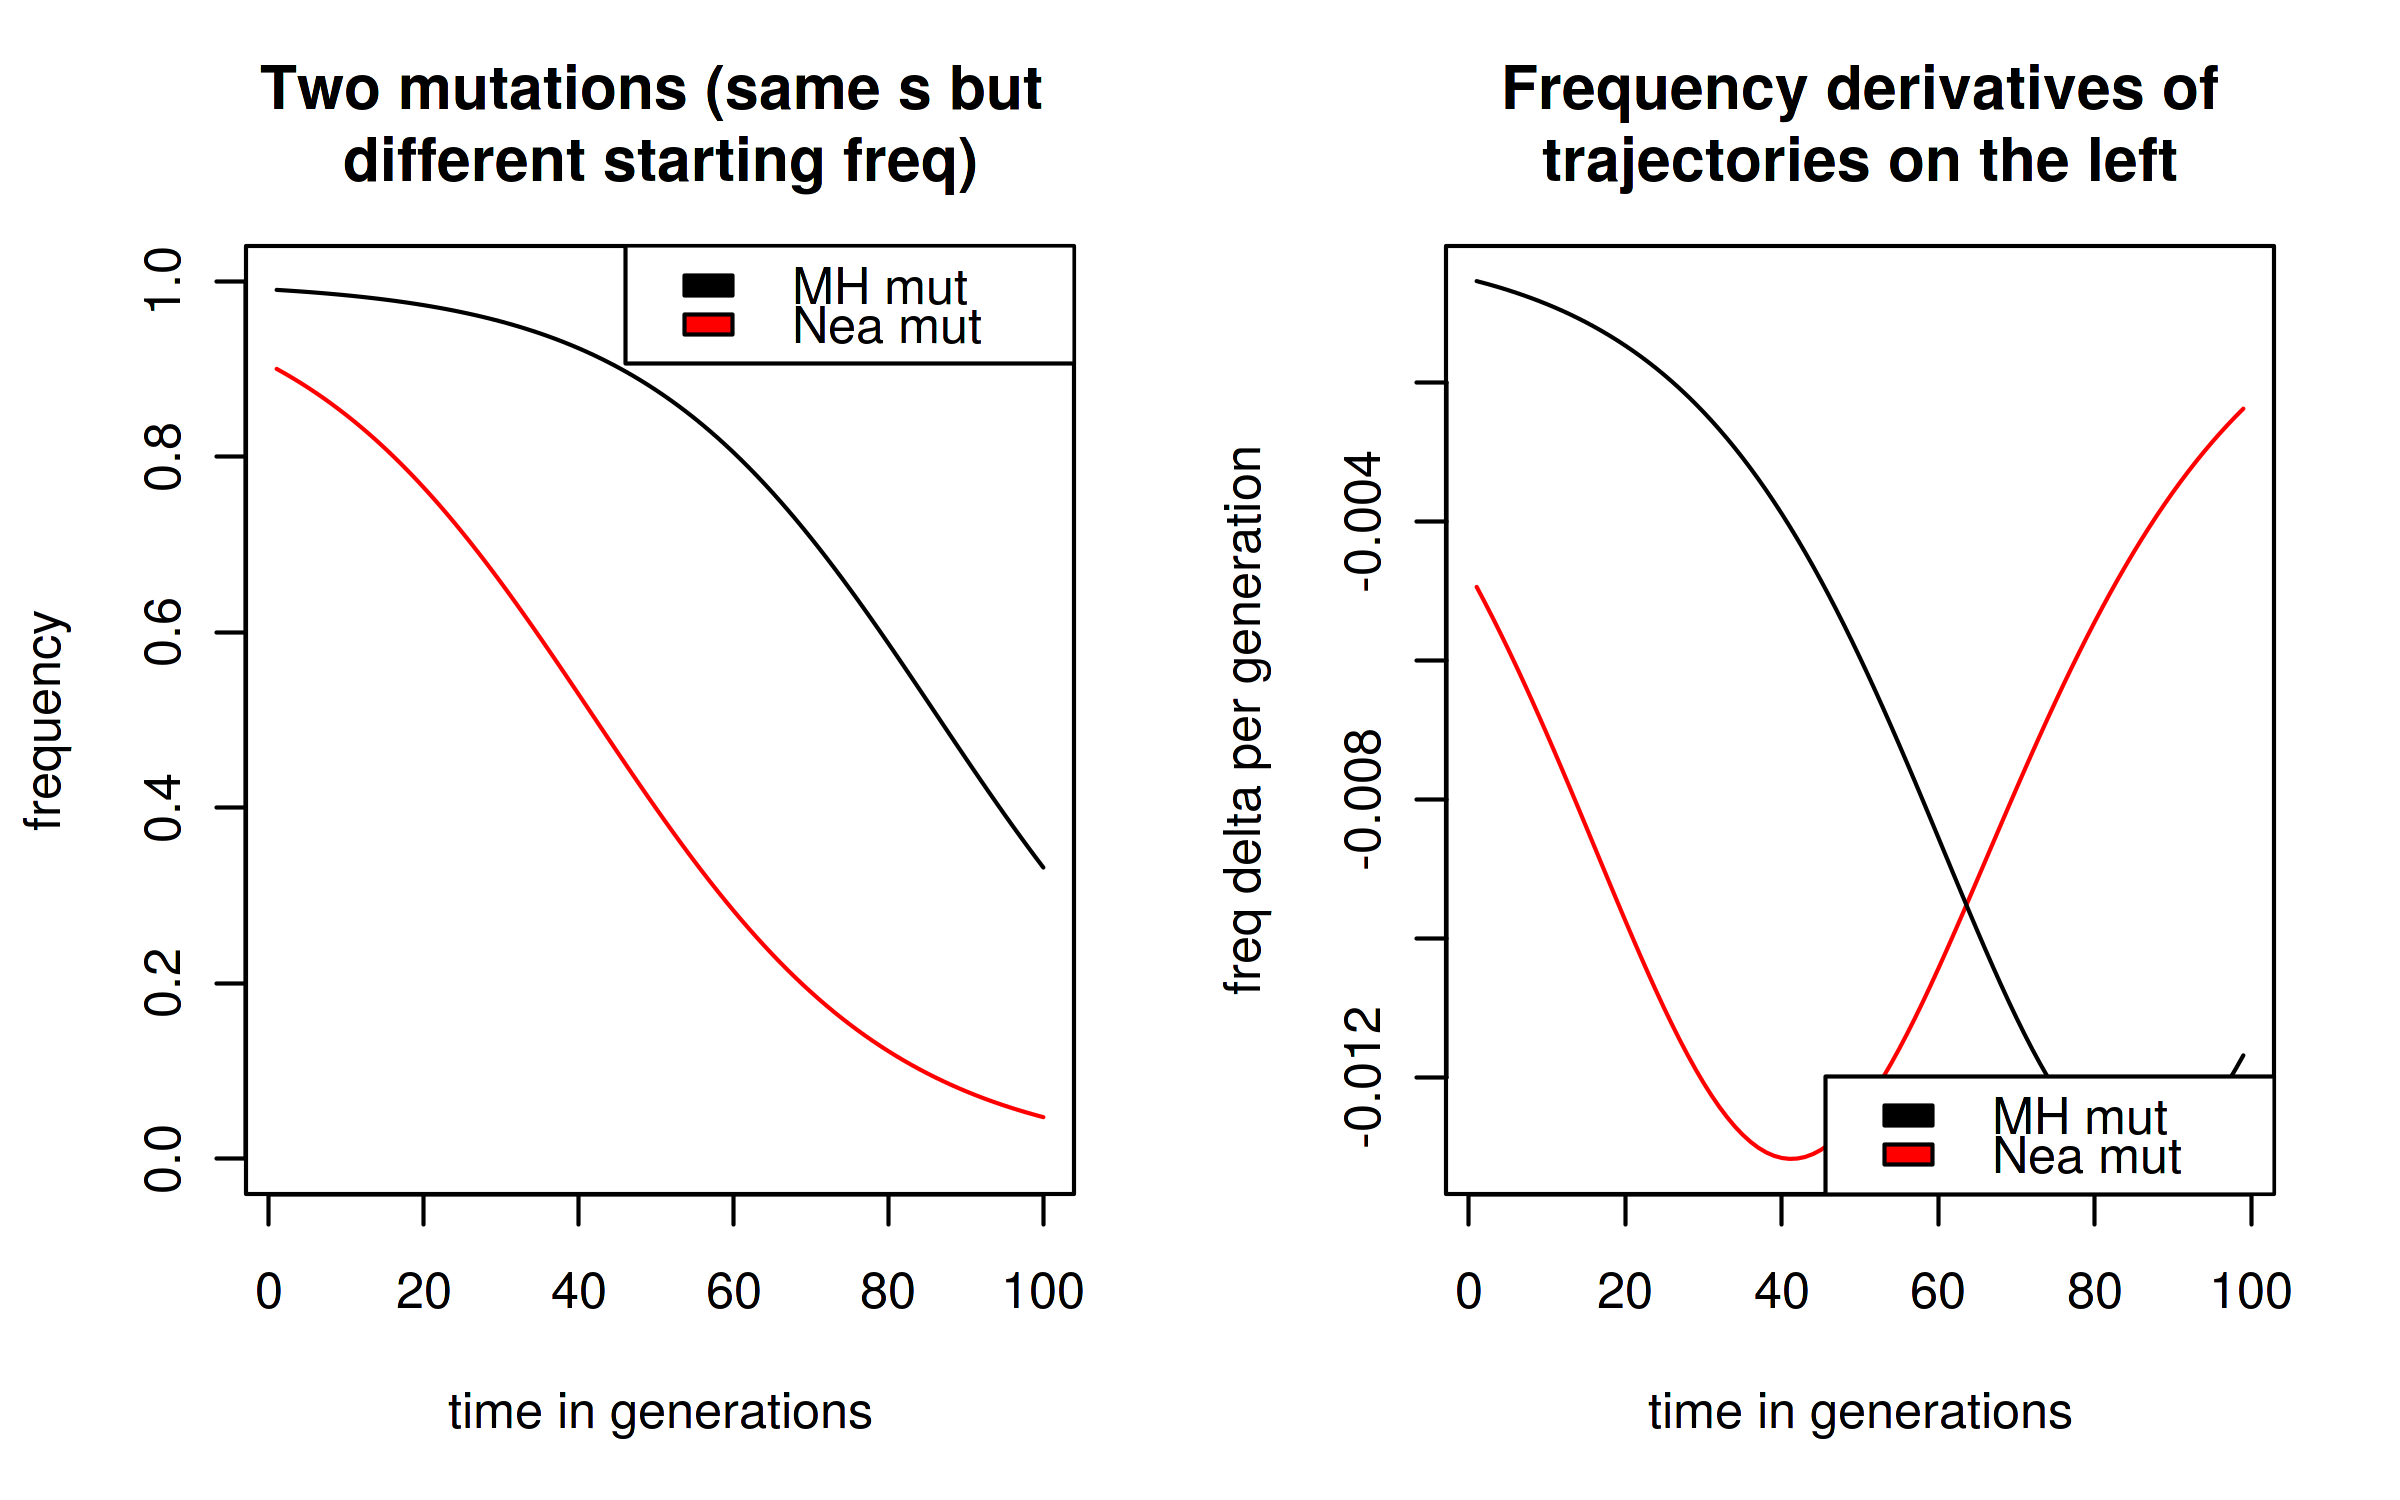

In [98]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=300)

n <- 100
mh <- simulate_selection(0.99, -0.1, 0.5, n) %>% .[, 1]
nea <- simulate_selection(0.9, -0.1, 0.5, n) %>% .[, 1]

par(mfrow=c(1, 2))
plot(1:n, mh, ylim=c(0, 1), type="l", ylab="frequency", xlab="time in generations",
     main="Two mutations (same s but \ndifferent starting freq)")
lines(1:n, nea, col="red")
legend("topright", fill=c("black", "red"), legend=c("MH mut", "Nea mut"))

plot(1:(n-1), diff(nea), col="red", type="l", ylab="freq delta per generation", xlab="time in generations",
     main="Frequency derivatives of\ntrajectories on the left",
     ylim=c(min(c(diff(nea), diff(mh))), max(c(diff(nea), diff(mh)))))
lines(1:(n-1), diff(mh))
legend("bottomright", fill=c("black", "red"), legend=c("MH mut", "Nea mut"))